# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../../optimiser/')

In [2]:
import pandas as pd
import patsy
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from mlens.ensemble import SuperLearner
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import optimiser
import scipy.stats
import itertools

[MLENS] backend: threading


# Getting data

In [3]:
file_name = '../csvs/element_gameweek_features_v06.csv'

In [4]:
element_gameweek_df = pd.read_csv(file_name)

In [5]:
element_gameweek_df.fillna(
    element_gameweek_df[element_gameweek_df['event'] <= 20].mean(),
    inplace=True
)

In [6]:
all_element_gameweek_df = element_gameweek_df.copy()

In [7]:
all_element_gameweek_df['predicted_total_points'] = 0

In [26]:
[i for i in list(element_gameweek_df.columns) if i not in [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     
     'expected_total_points_against_opposition_team',
     'rolling_avg_total_points_element_home',
     'rolling_max_total_points_element',
     'rolling_avg_bps_element',
     'expected_total_points_element_home_away',
     'rolling_avg_total_points_element_away',
     'rolling_avg_total_points_own_team',
     'rolling_avg_total_points_against_opposition_team',
     'rolling_avg_minutes_element',
     'rolling_avg_total_points_opposition_team',
     'rolling_avg_dribbles_element',
     'rolling_avg_total_points_against_opposition_team_element_type',
     'rolling_avg_total_points_against_opposition_team_element_type_away',
     'rolling_avg_total_points_against_opposition_team_element_type_home',
     'rolling_avg_goals_conceded_element',
     'rolling_avg_completed_passes_element',
     'rolling_avg_total_points_element_type',
     'rolling_avg_recoveries_element',
]]

['was_home',
 'is_sunday',
 'is_weekday',
 'is_early',
 'is_late',
 'value',
 'rolling_avg_total_points_element',
 'has_high_points_ever_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rolling_avg_offside_element',
 'rolling_avg_big_chances_missed_element',
 'rolling_avg_saves_element',
 'rolling_avg_attempted_passes_element',
 'rolling_avg_errors_leading_to_goal_element',
 'rolling_avg_errors_leading_to_goal_attempt_element',
 'rolling_avg_own_goals_element',
 'rolling_avg_penalties_concededd_element',
 'rolling_avg_penalties_missed_element',
 'r

# Evaluating models

## Helpers

### Modelling

In [70]:
formula = \
'total_points ~ C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     
     'expected_total_points_against_opposition_team',
     'rolling_avg_total_points_element_home',
     'rolling_max_total_points_element',
     'rolling_avg_bps_element',
     'expected_total_points_element_home_away',
     'rolling_avg_total_points_element_away',
     'rolling_avg_total_points_own_team',
     'rolling_avg_total_points_against_opposition_team',
     'rolling_avg_minutes_element',
     'rolling_avg_total_points_opposition_team',
     'rolling_avg_dribbles_element',
     'rolling_avg_total_points_against_opposition_team_element_type',
     'rolling_avg_total_points_against_opposition_team_element_type_away',
     'rolling_avg_total_points_against_opposition_team_element_type_home',
     'rolling_avg_goals_conceded_element',
     'rolling_avg_completed_passes_element',
     'rolling_avg_total_points_element_type',
     'rolling_avg_recoveries_element',
 ]])

In [71]:
scaled_feature_cols = [
    i for i in element_gameweek_df.columns if i not in [
        'safe_web_name', 'element', 'event', 'fixture', 'team',
        'opposition_team', 'element_type', 'was_home', 'is_sunday',
        'is_weekday', 'is_late', 'is_early', 'has_high_points_ever_element',
        'total_points', 'minutes', 'rolling_value_points'
    ]
]

In [72]:
def calculate_expected_total_points_against_opposition_team_home_away(row):
    a = 'rolling_avg_total_points_against_opposition_team_element_type_home'
    b = 'rolling_avg_total_points_against_opposition_team_element_type_away'
    c = 'rolling_avg_total_points_element'
    d = 'rolling_avg_total_points_element_type'
    if row['was_home'] == 1:
        return row[a] * row[c] / row[d]
    else:
        return row[b] * row[c] / row[d]


def munge_data(df, e, prediction_events, minute_threshold=60):
    # filter weeks after test week
    event_df = df.copy()
    event_df = event_df[event_df['event'] <= e + prediction_events - 1]

    cols = event_df.columns

    # columns that we can fill down
    unknown_element_cols = [
        'was_home',
        'is_sunday',
        'is_weekday',
        'is_early',
        'is_late',
        'value',
        'rolling_avg_total_points_element',
        'has_high_points_ever_element',
        'rolling_avg_bonus_element',
        'rolling_avg_goals_scored_element',
        'rolling_avg_clean_sheets_element',
        'rolling_avg_assists_element',
        'rolling_avg_key_passes_element',
        'rolling_avg_winning_goals_element',
        'rolling_avg_tackled_element',
        'rolling_avg_clearances_blocks_interceptions_element',
        'rolling_avg_big_chances_created_element',
        'rolling_avg_target_missed_element',
        'rolling_avg_fouls_element',
        'rolling_avg_tackles_element',
        'rolling_avg_open_play_crosses_element',
        'rolling_avg_offside_element',
        'rolling_avg_big_chances_missed_element',
        'rolling_avg_saves_element',
        'rolling_avg_attempted_passes_element',
        'rolling_avg_errors_leading_to_goal_element',
        'rolling_avg_errors_leading_to_goal_attempt_element',
        'rolling_avg_own_goals_element',
        'rolling_avg_penalties_concededd_element',
        'rolling_avg_penalties_missed_element',
        'rolling_avg_penalties_saved_element',
        'rolling_avg_red_cards_element',
        'rolling_avg_yellow_cards_element',
        'rolling_avg_minutes_element_p3',
        'rolling_avg_total_points_element_p3',
        'rolling_avg_goals_scored_opposition_team',
        'rolling_avg_goals_conceded_opposition_team',
        'rolling_avg_total_points_element_type',
    ]

    # columns we need to look up
    unknown_opposition_cols = [
        'rolling_avg_goals_scored_opposition_team',
        'rolling_avg_goals_conceded_opposition_team',
        'rolling_avg_total_points_against_opposition_team_element_type_home',
        'rolling_avg_total_points_against_opposition_team_element_type_away',
    ]

    # columns we need to calculate
    unknown_engineered_cols = [
        'expected_total_points_against_opposition_team_home_away',
    ]

    # fill in nans for future data we wouldn't know
    event_df.loc[event_df['event'] > e,
                 unknown_element_cols + unknown_opposition_cols + unknown_engineered_cols
                ] = np.nan
    event_df.sort_values(['element', 'event', 'fixture'], inplace=True)
    # fill down the element data
    event_df[unknown_element_cols] = event_df[unknown_element_cols].fillna(method='ffill')

    # create look up tables for opposition team data
    # we have to look two events back, as some teams won't have played last event
    against_opposition_event_df_1 = event_df[event_df['event'] == e][
        ['opposition_team','element_type','event'] + unknown_opposition_cols].drop_duplicates()


    against_opposition_event_df_2 = event_df[event_df['event'] == e - 1][
        ['opposition_team','element_type','event'] + unknown_opposition_cols].drop_duplicates()

    against_opposition_event_df = pd.concat([against_opposition_event_df_1, against_opposition_event_df_2])

    # get the most recent opposition team data
    against_opposition_event_df = against_opposition_event_df.join(
        against_opposition_event_df.groupby(['opposition_team', 'element_type'])['event'].max(),
        on=['opposition_team', 'element_type'],
        rsuffix='_most_recent')

    against_opposition_event_df = \
    against_opposition_event_df[against_opposition_event_df['event'] == against_opposition_event_df['event_most_recent']]

    event_df = event_df.join(
        against_opposition_event_df.set_index(['opposition_team', 'element_type']),
        on=['opposition_team', 'element_type'],
        rsuffix='_fill')

    # fill in opposition team data from lookup table
    for i in unknown_opposition_cols:
        event_df.loc[event_df['event'] > e, i] = event_df[event_df['event'] > e][i+'_fill']

    event_df['expected_total_points_against_opposition_team_home_away'] = \
    event_df.apply(calculate_expected_total_points_against_opposition_team_home_away, axis=1)

    # filter for frequently appearing players
    event_df = event_df[event_df['rolling_avg_minutes_element_p3'] >= minute_threshold][cols]
    
    return event_df


def split_data(event_df, last_train_event, last_test_event):
    # define train-test split
    test_fold = [-1 if i <= last_train_event else 0 for i in event_df['event'] if i <= last_test_event]
    ps = PredefinedSplit(test_fold)

    # split df into train and test
    for train_index, test_index in ps.split():
        event_df_train, event_df_test = \
        event_df.copy().iloc[train_index], event_df.copy().iloc[test_index]
    
    return event_df_train, event_df_test, ps


def standardise_data(event_df, event_df_train, event_df_test, scaled_feature_cols):
    scale_train = event_df_train.copy()
    scale_test = event_df_test.copy()
    scale_df = event_df.copy()
    scaled_event_df_train = event_df_train.copy()
    scaled_event_df_test = event_df_test.copy()
    scaled_event_df = event_df.copy()

    scaler = StandardScaler().fit(scale_train[scaled_feature_cols].values)

    scale_train = scaler.transform(scale_train[scaled_feature_cols].values)
    scale_test = scaler.transform(scale_test[scaled_feature_cols].values)
    scale_df = scaler.transform(scale_df[scaled_feature_cols].values)

    scaled_event_df_train[scaled_feature_cols] = scale_train
    scaled_event_df_test[scaled_feature_cols] = scale_test
    scaled_event_df[scaled_feature_cols] = scale_df
    
    return scaled_event_df_train, scaled_event_df_test, scaled_event_df


def get_pcs(event_X_train, event_X_test, n_categorical_features):
    pca = PCA()
    pca.fit(event_X_train[:,(n_categorical_features + 1):])
    
    event_X_train_pca = np.concatenate(
        (
            event_X_train[:,:(n_categorical_features + 1)],
            pca.transform(event_X_train[:,(n_categorical_features + 1):])
        ), axis=1)
    
    event_X_test_pca = np.concatenate(
        (
            event_X_test[:,:(n_categorical_features + 1)],
            pca.transform(event_X_test[:,(n_categorical_features + 1):])
        ), axis=1)
    
    return event_X_train_pca, event_X_test_pca


def split_matrices(event_X, event_y, ps):
    for train_index, test_index in ps.split():
        event_X_train, event_X_test = event_X[train_index], event_X[test_index]
        event_y_train, event_y_test = event_y[train_index], event_y[test_index]
    
    return event_X_train, event_X_test, event_y_train, event_y_test


def select_features(event_X, event_X_train, event_X_test, features_index):    
    event_X_train_sel = event_X_train[:,features_index]
    event_X_test_sel = event_X_test[:,features_index]
    event_X_sel = event_X[:,features_index]
    
    return event_X_train_sel, event_X_test_sel, event_X_sel


def retune_model(event_df,
                 last_train_event,
                 last_validation_event,
                 standardise,
                 features_index,
                 model,
                 parameter_space,
                 n_iter_tune=100):
    
    # split data into train and validation set
    event_df_train, event_df_validation, ps_tune = split_data(event_df, last_train_event, last_validation_event)

    # standardise appropriate variables if necessary
    scaled_event_df = event_df.copy()
    if standardise:
        scaled_event_df_train, scaled_event_df_validation, scaled_event_df = \
        standardise_data(event_df, event_df_train, event_df_validation, scaled_feature_cols)        

    # get reponse vector and feature matrix
    event_y, event_X = patsy.dmatrices(formula, scaled_event_df, return_type='matrix')

    # split response vector and feature matrix into train and test
    event_X_train, event_X_validation, event_y_train, event_y_validation = \
    split_matrices(event_X, event_y, ps_tune)

    # if only certain features selected, get their indices
    event_X_train_sel = event_X_train
    event_X_validation_sel = event_X_validation
    event_X_sel = event_X
    if features_index:
        event_X_train_sel, event_X_validation_sel, event_X_sel = \
        select_features(event_X, event_X_train, event_X_validation, features_index)
    
    # search hyperparameter space
    tuner = RandomizedSearchCV(
        model,
        parameter_space,
        n_iter=n_iter_tune,
        scoring='neg_mean_squared_error',
        refit=True,
        cv=ps_tune,
        error_score=100, n_jobs=1)
    
    tuner.fit(event_X_sel, event_y.ravel())
    
    return tuner.best_estimator_

### Predicting points

In [88]:
def predict_test_set(df,
                     model,
                     parameter_space=False,
                     prediction_events=1,
                     features_index=False,
                     standardise=False,
                     pcs=False,
                     start=21,
                     end=38,
                     n_iter_tune=100,
                     verbose=0):
    y_pred_arr = []
    y_test_arr = []
    event_df_test_arr = []

    # for each event we want to predict
    for e in range(start, end + 1):
        if verbose > 0:
            print('predicting event', e)
        
        # munge data
        event_df = munge_data(df, e, prediction_events, minute_threshold=60)

        # split df into train and test
        event_df_train, event_df_test, ps = split_data(event_df, e - 1, 38)
        
        # standardise appropriate variables if necessary
        scaled_event_df = event_df.copy()
        if standardise:
            scaled_event_df_train, scaled_event_df_test, scaled_event_df = \
            standardise_data(event_df, event_df_train, event_df_test, scaled_feature_cols)        

        # get reponse vector and feature matrix
        event_y, event_X = patsy.dmatrices(formula, scaled_event_df, return_type='matrix')
        
        # split response vector and feature matrix into train and test
        event_X_train, event_X_test, event_y_train, event_y_test = \
        split_matrices(event_X, event_y, ps)
        
        # get pcs if necessary
        if pcs:
            n_categorical_features = event_X.design_info.column_names.index('value') - 1
            event_X_train, event_X_test = get_pcs(event_X_train, event_X_test, n_categorical_features)
        
        # if only certain features selected, get their indices
        event_X_train_sel = event_X_train
        event_X_test_sel = event_X_test
        event_X_sel = event_X
        if features_index:
            event_X_train_sel, event_X_test_sel, event_X_sel = \
            select_features(event_X, event_X_train, event_X_test, features_index)
            
        # retune hyperparameters
        if parameter_space:
            model = retune_model(event_df,
                                 e - 6,
                                 e - 1,
                                 standardise,
                                 features_index,
                                 model,
                                 parameter_space,
                                 n_iter_tune)

        # fit model on training data
        model.fit(event_X_train_sel, event_y_train.ravel())
        # predict test event
        event_y_pred = model.predict(event_X_test_sel).flatten()
        
        # collect predictions and observations 
        y_pred_arr.append(event_y_pred)
        y_test_arr.append(event_y_test)
        
        event_df_test['predicted_total_points'] = event_y_pred
        event_df_test['prediction_event'] = e
        event_df_test_arr.append(event_df_test)
        
    
    return np.concatenate(y_pred_arr).ravel(), np.concatenate(y_test_arr).ravel(), pd.concat(event_df_test_arr)

## Predicting points

### Linear regression

In [240]:
lr_model = LinearRegression()

In [241]:
lr_features_index = [
    False, True, True, True, True, False, False, False, True, True, True, True,
    True, False, True, False, True, False, True, True, False, False, True,
    True, True, True, True, False, True, True, True, True, True, True, True,
    True, True, True, False, True, True, True, True, False, True, True, True,
    True, False, False, False, False, False, False, True, True, False, False,
    False, False, False, False, False, False, True, False, False, False, False,
    False, True, False, False, False, False, True, True, True, False, False
]

In [242]:
lr_y_pred, lr_y_test, lr_df_test = predict_test_set(
    element_gameweek_df,
    lr_model,
    standardise=True,
    features_index=lr_features_index,
    pcs=False,
    prediction_events=1,
    verbose=True
)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [243]:
lr_test_loss = (
    mean_absolute_error(lr_y_test, lr_y_pred),
    mean_squared_error(lr_y_test, lr_y_pred),
    r2_score(lr_y_test, lr_y_pred)
)
lr_test_loss

(2.239941956554309, 9.389361279792645, 0.08597038730110373)

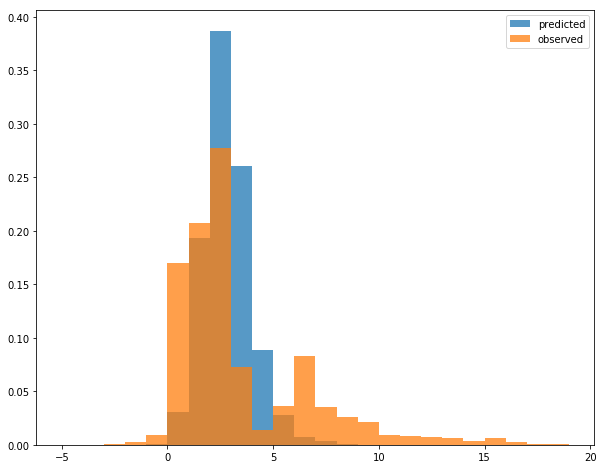

In [244]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lr_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(lr_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

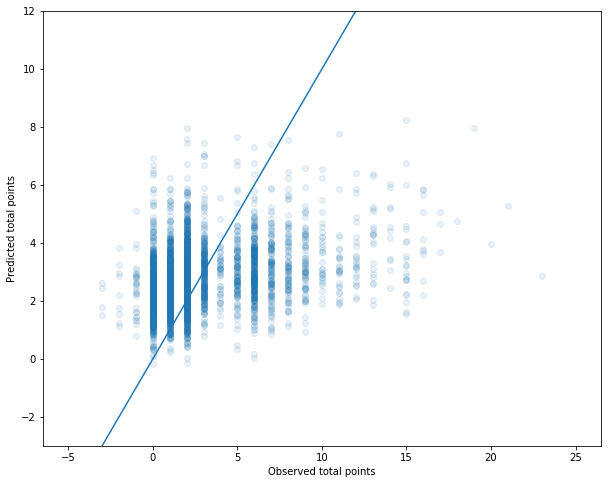

In [245]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(lr_y_test), pd.Series(lr_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Ridge regression

In [248]:
ridge_model = Ridge(alpha=1e-8)

In [249]:
ridge_features_index = [
    False, False, False, False, False, False, False, False, False, False,
    False, False, False, False, True, False, False, False, False, False, False,
    False, False, False, False, False, False, False, False, False, True, False,
    False, True, False, False, False, False, False, False, False, False, False,
    False, False, False, False, True, False, False, False, False, False, False,
    True, False, False, False, False, False, False, False, False, False, True,
    True, False, False, False, False, False, False, False, False, False, True,
    False, True, False, True
]

In [250]:
ridge_y_pred, ridge_y_test, ridge_df_test = predict_test_set(
    element_gameweek_df,
    ridge_model,
    standardise=True,
    features_index=ridge_features_index,
    pcs=False,
    prediction_events=1,
    verbose=1
)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [251]:
ridge_test_loss = (
    mean_absolute_error(ridge_y_test, ridge_y_pred),
    mean_squared_error(ridge_y_test, ridge_y_pred),
    r2_score(ridge_y_test, ridge_y_pred)
)
ridge_test_loss

(2.24512081350227, 9.410741025318998, 0.0838891253344235)

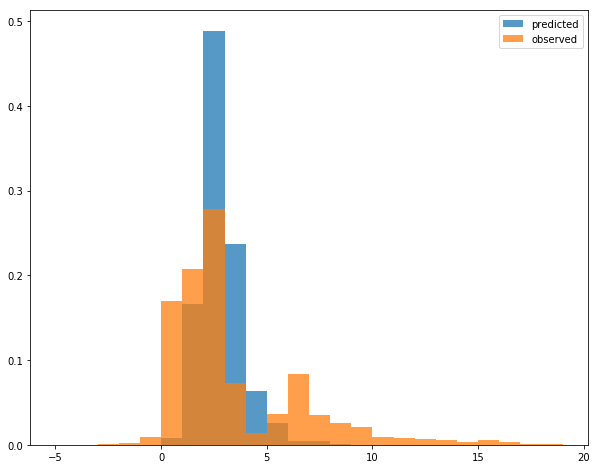

In [252]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(ridge_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(ridge_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

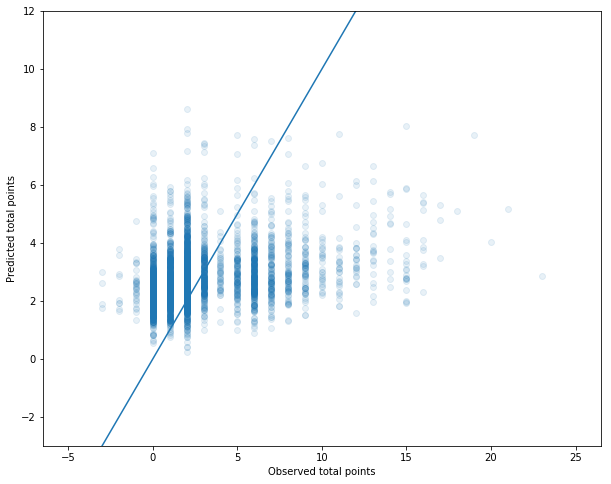

In [253]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(ridge_y_test), pd.Series(ridge_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Lasso regression

In [194]:
lasso_model = Lasso(alpha=1e-8)

In [254]:
lasso_features_index = [
    False, False, False, False, False, False, False, False, False, False,
    False, False, False, False, True, False, False, False, False, False, False,
    False, False, False, False, False, False, False, False, False, False,
    False, False, False, False, False, False, False, False, False, False,
    False, True, False, False, False, True, True, False, False, False, False,
    False, False, True, False, False, False, False, False, False, False, False,
    False, True, True, False, False, False, False, True, False, False, False,
    False, True, False, True, True, True
]

In [255]:
lasso_y_pred, lasso_y_test, lasso_df_test = predict_test_set(
    element_gameweek_df,
    lasso_model,
    standardise=True,
    features_index=lasso_features_index,
    pcs=False,
    prediction_events=1,
    verbose=1
)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [256]:
lasso_test_loss = (
    mean_absolute_error(lasso_y_test, lasso_y_pred),
    mean_squared_error(lasso_y_test, lasso_y_pred),
    r2_score(lasso_y_test, lasso_y_pred)
)
lasso_test_loss

(2.2226890673411943, 9.351105071243412, 0.08969452853303594)

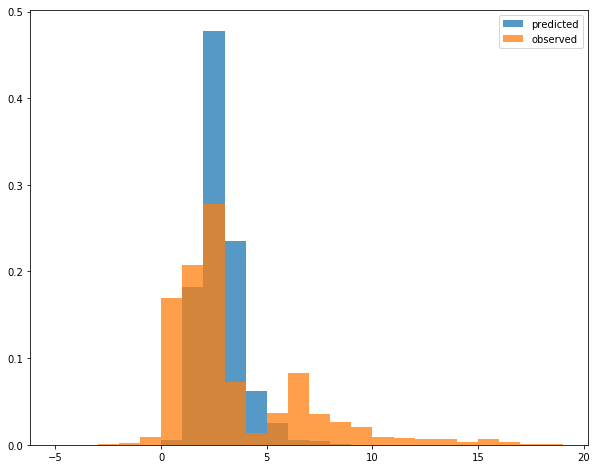

In [257]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lasso_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(lasso_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

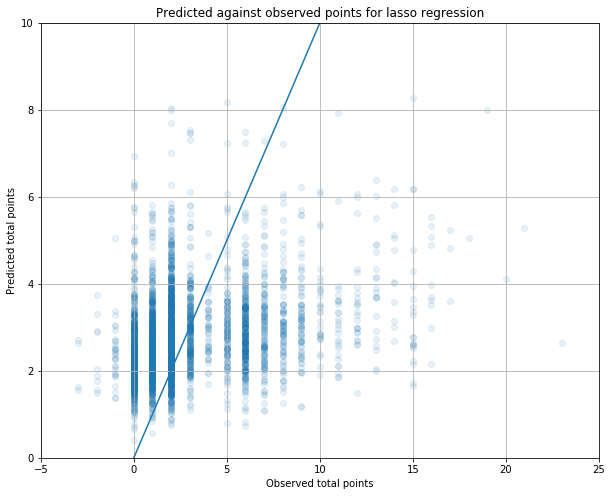

In [438]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(lasso_y_test), pd.Series(lasso_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.title('Predicted against observed points for lasso regression')
plt.grid()
plt.ylim(, 10)
plt.xlim(-5, 25)
plt.show()

### Principal component regression

In [259]:
pc_model = LinearRegression()

In [260]:
pc_features_index = [
    False, False, True, False, False, False, False, False, False, False, False,
    False, False, False, True, False, False, False, False, False, False, False,
    False, False, False, False, False, False, False, False, True, False, False,
    True, False, False, False, False, False, False, False, False, True, False,
    False, False, True, True, True, True, True, True, True, False, False,
    False, True, True, False, False, True, True, True, True, True, False, True,
    False, False, False, False, False, True, False, True, True, True, False,
    False, False
]

In [261]:
pc_y_pred, pc_y_test, pc_df_test = predict_test_set(
    element_gameweek_df,
    pc_model,
    standardise=True,
    features_index=pc_features_index,
    pcs=True,
    prediction_events=1,
    verbose=1
)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [262]:
pc_test_loss = (
    mean_absolute_error(pc_y_test, pc_y_pred),
    mean_squared_error(pc_y_test, pc_y_pred),
    r2_score(pc_y_test, pc_y_pred)
)
pc_test_loss

(2.235766618343501, 9.382369664597682, 0.08665100264205827)

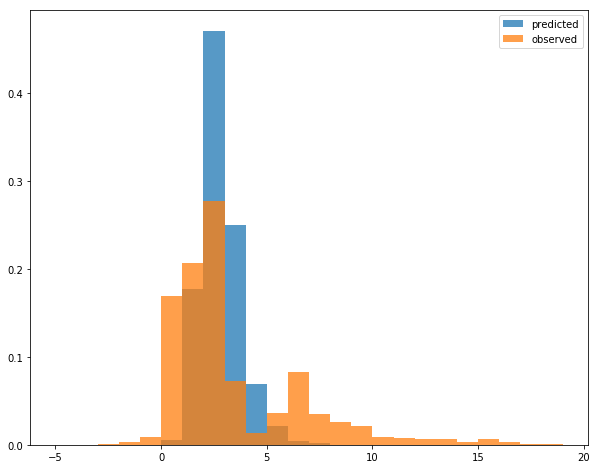

In [263]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(pc_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(pc_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

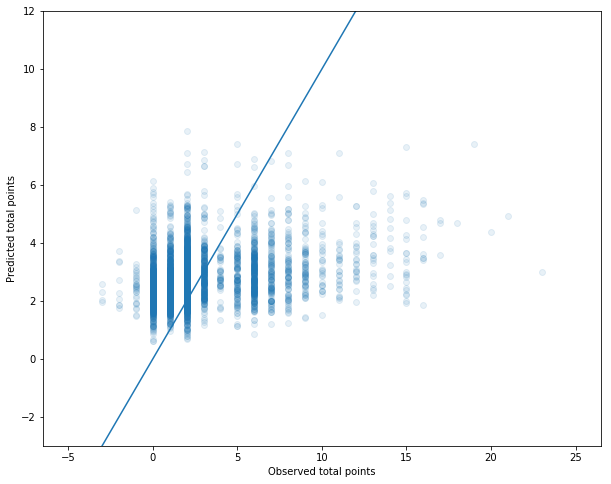

In [264]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(pc_y_test), pd.Series(pc_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Linear kernel

In [265]:
linear_model = SVR(kernel='linear', epsilon=1.92, C=3.05)

In [266]:
linear_features_index = [
    False, False, False, False, False, False, False, False, False, False,
    False, False, False, False, True, False, False, False, False, False, False,
    False, False, False, False, False, False, False, False, False, True, False,
    False, True, False, False, False, False, False, False, False, False, False,
    False, False, False, False, True, False, False, False, False, False, False,
    True, False, False, False, False, False, False, False, False, False, True,
    True, False, False, False, False, False, False, False, False, False, True,
    False, True, False, True
]

In [267]:
linear_y_pred, linear_y_test, linear_df_test = predict_test_set(
    element_gameweek_df,
    linear_model,
    features_index=linear_features_index,
    standardise=True,
    prediction_events=1,
    verbose=1
)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [268]:
linear_test_loss = (
    mean_absolute_error(linear_y_test, linear_y_pred),
    mean_squared_error(linear_y_test, linear_y_pred),
    r2_score(linear_y_test, linear_y_pred)
)
linear_test_loss

(2.237943155954428, 9.482504288801866, 0.0769031604777487)

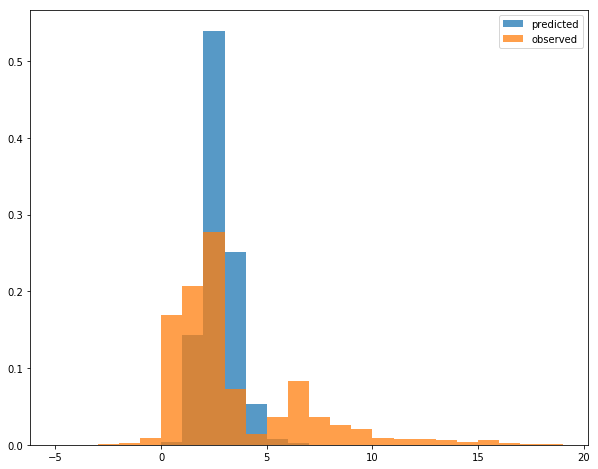

In [269]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(linear_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(linear_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

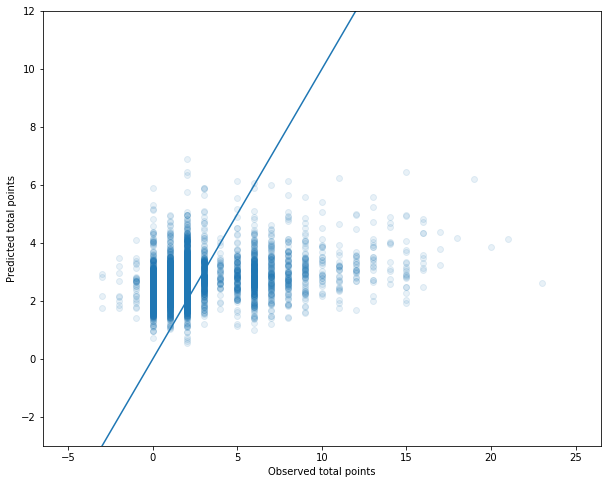

In [270]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(linear_y_test), pd.Series(linear_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### RBF kernel

In [271]:
rbf_model = SVR(kernel='rbf', epsilon=1.95, C=100, gamma=0.00103)

In [272]:
rbf_features_index = [
    False, False, False, False, False, False, False, False, False, False,
    False, False, False, False, True, False, False, False, False, False, False,
    False, False, False, False, False, False, False, False, False, True, False,
    False, True, False, False, False, False, False, False, False, False, False,
    False, False, False, False, True, False, False, False, False, False, False,
    True, False, False, False, False, False, False, False, False, False, True,
    True, False, False, False, False, False, False, False, False, False, True,
    False, True, False, True
]

In [273]:
rbf_y_pred, rbf_y_test, rbf_df_test = predict_test_set(
    element_gameweek_df,
    rbf_model,
    features_index=rbf_features_index,
    standardise=True,
    prediction_events=1,
    verbose=1
)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [274]:
rbf_test_loss = (
    mean_absolute_error(rbf_y_test, rbf_y_pred),
    mean_squared_error(rbf_y_test, rbf_y_pred),
    r2_score(rbf_y_test, rbf_y_pred)
)
rbf_test_loss

(2.2469851833956107, 9.444073204341619, 0.08064432541943611)

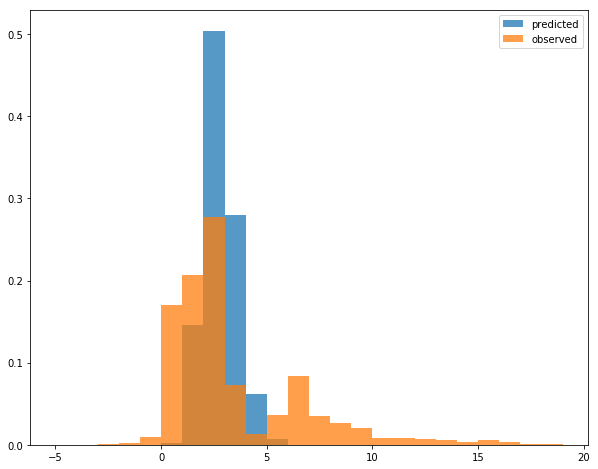

In [275]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(rbf_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(rbf_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

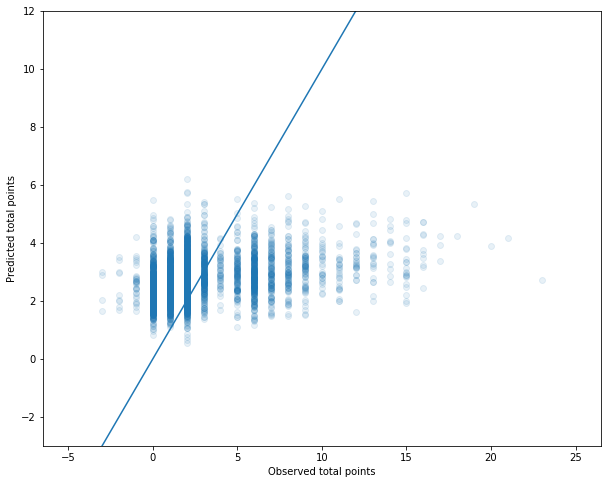

In [276]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(rbf_y_test), pd.Series(rbf_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Decision tree

In [277]:
tree_model = DecisionTreeRegressor(min_samples_leaf=0.0193)

In [278]:
tree_y_pred, tree_y_test, tree_df_test = predict_test_set(
    element_gameweek_df,
    tree_model,
    standardise=False,
    prediction_events=1,
    verbose=1
)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [279]:
tree_test_loss = (
    mean_absolute_error(tree_y_test, tree_y_pred),
    mean_squared_error(tree_y_test, tree_y_pred),
    r2_score(tree_y_test, tree_y_pred)
)
tree_test_loss

(2.2841181729603743, 9.742257927785564, 0.05161682725843064)

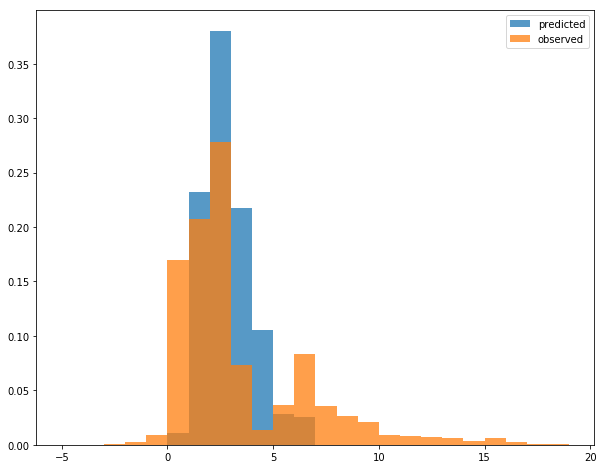

In [280]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(tree_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(tree_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

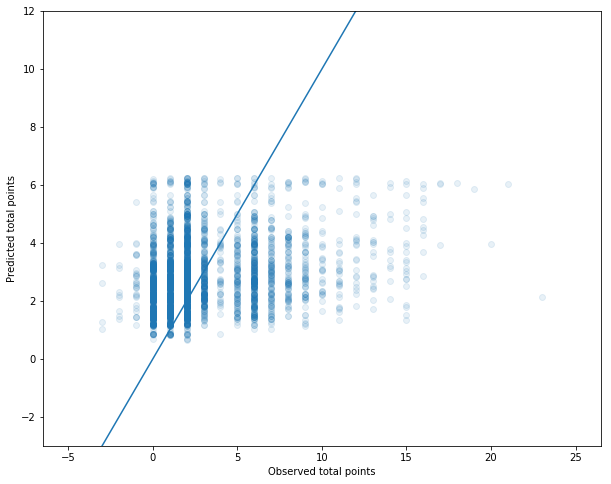

In [281]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(tree_y_test), pd.Series(tree_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Random forest

In [ ]:
forest_test_loss_arr = []

for i in range(0, 100):
    print('prediction iteration ', i)
    forest_model = RandomForestRegressor(
        criterion='mse',
        n_estimators=500,
        min_samples_leaf=0.0156,
        max_features=0.9)

    forest_y_pred, forest_y_test, forest_df_test = predict_test_set(
        element_gameweek_df,
        forest_model,
        standardise=False,
        prediction_events=1,
        verbose=0
    )
    
    forest_test_loss = (
    mean_absolute_error(forest_y_test, forest_y_pred),
    mean_squared_error(forest_y_test, forest_y_pred),
    r2_score(forest_y_test, forest_y_pred)
    )
    
    forest_test_loss_arr.append(forest_test_loss)

prediction iteration  0
prediction iteration  1
prediction iteration  2
prediction iteration  3
prediction iteration  4
prediction iteration  5
prediction iteration  7
prediction iteration  8
prediction iteration  9
prediction iteration  10
prediction iteration  12
prediction iteration  13
prediction iteration  14
prediction iteration  15
prediction iteration  16
prediction iteration  17
prediction iteration  18


In [302]:
forest_test_loss = \
[np.mean([i[j] for i in forest_test_loss_arr]) for j in range(0, 3)]

forest_test_loss_std = \
[np.std([i[j] for i in forest_test_loss_arr]) for j in range(0, 3)]


forest_test_loss, forest_test_loss_std

([2.2480562591785525, 9.411871436444562, 0.08377908278600056],
 [0.0007120064612951759, 0.004304524714643791, 0.000419034153712489])

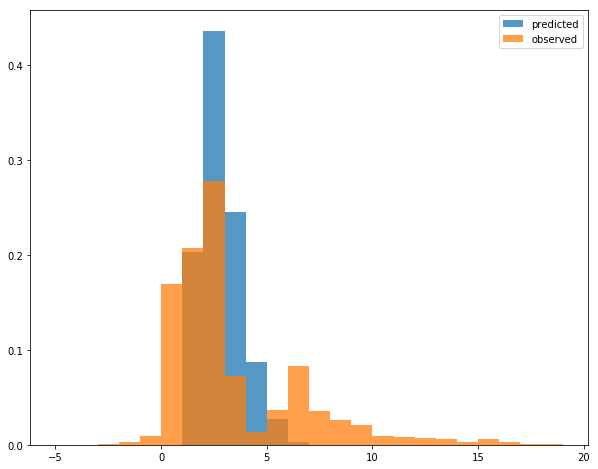

In [303]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(forest_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(forest_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

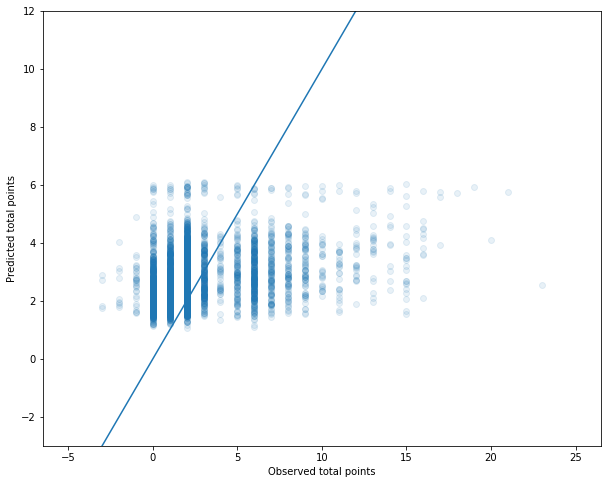

In [304]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(forest_y_test), pd.Series(forest_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Gradient boosted trees

In [ ]:
boost_test_loss_arr = []

for i in range(0, 100):
    print('prediction iteration ', i)
    boost_model = GradientBoostingRegressor(
        criterion='mse',
        min_samples_leaf=0.0175,
        max_features=1.0,
        learning_rate=0.02,
        subsample=0.3,
        n_estimators=200
    )

    boost_y_pred, boost_y_test, boost_df_test = predict_test_set(
        element_gameweek_df,
        boost_model,
        standardise=False,
        prediction_events=1,
        verbose=0
    )
    
    boost_test_loss = (
    mean_absolute_error(boost_y_test, boost_y_pred),
    mean_squared_error(boost_y_test, boost_y_pred),
    r2_score(boost_y_test, boost_y_pred)
    )
    
    boost_test_loss_arr.append(boost_test_loss)

In [305]:
boost_test_loss = \
[np.mean([i[j] for i in boost_test_loss_arr]) for j in range(0, 3)]

boost_test_loss_std = \
[np.std([i[j] for i in boost_test_loss_arr]) for j in range(0, 3)]


boost_test_loss, boost_test_loss_std

([2.2422876193271506, 9.41809274835006, 0.08317345444324015],
 [0.0018954725206160666, 0.010064356628737765, 0.0009797386336839224])

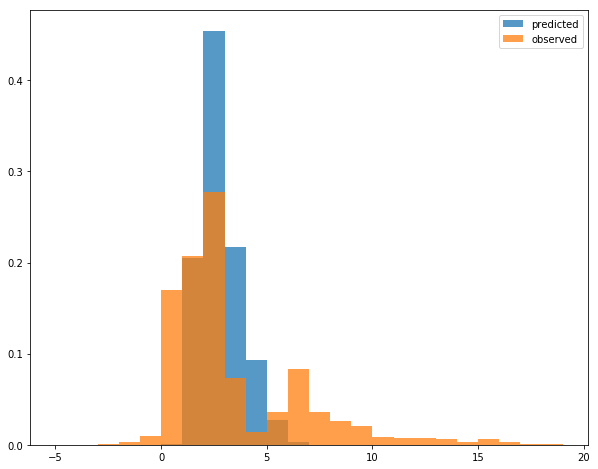

In [306]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(boost_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(boost_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

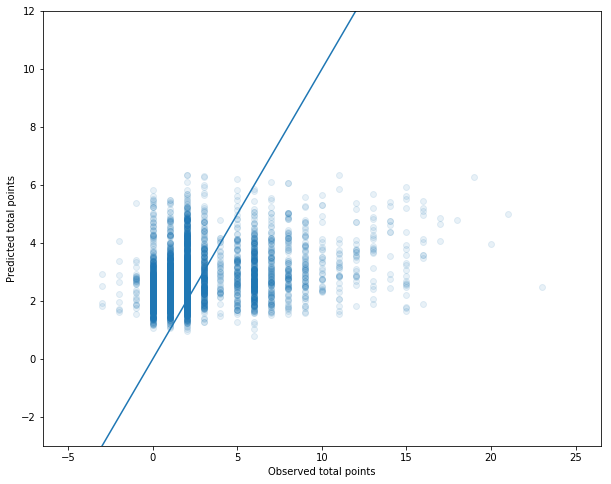

In [307]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(boost_y_test), pd.Series(boost_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

# Summary

In [430]:
pd.DataFrame([
    ('Linear regression', lr_test_loss[0], lr_test_loss[1], lr_test_loss[2]),
    ('Ridge regression', ridge_test_loss[0], ridge_test_loss[1], ridge_test_loss[2]),
    ('Lasso regression', lasso_test_loss[0], lasso_test_loss[1], lasso_test_loss[2]),
    ('Principal component regression', pc_test_loss[0], pc_test_loss[1], pc_test_loss[2]),
    ('Linear kernel', linear_test_loss[0], linear_test_loss[1], linear_test_loss[2]),
    ('RBF kernel', rbf_test_loss[0], rbf_test_loss[1], rbf_test_loss[2]),
    ('Decision tree', tree_test_loss[0], tree_test_loss[1], tree_test_loss[2]),
    ('Random forest', forest_test_loss[0], forest_test_loss[1], forest_test_loss[2]),
    ('Gradient boosted trees', boost_test_loss[0], boost_test_loss[1], boost_test_loss[2]),
#     ('Stacked ensemble', stack_test_loss[0], stack_test_loss[1], stack_test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Linear regression,2.239942,9.389361,0.085970
1,Ridge regression,2.245121,9.410741,0.083889
2,Lasso regression,2.222689,9.351105,0.089695
3,Principal component regression,2.235767,9.382370,0.086651
4,Linear kernel,2.237943,9.482504,0.076903
5,RBF kernel,2.246985,9.444073,0.080644
6,Decision tree,2.284118,9.742258,0.051617
7,Random forest,2.248056,9.411871,0.083779
8,Gradient boosted trees,2.242288,9.418093,0.083173


# Analysis

In [405]:
lasso_df_test['squared_error'] = ( lasso_df_test['predicted_total_points'] - lasso_df_test['total_points'] )**2
tree_df_test['squared_error'] = ( tree_df_test['predicted_total_points'] - tree_df_test['total_points'] )**2

##### Error by week

In [415]:
np.corrcoef(
    lasso_df_test.groupby('event')['total_points'].var(),
    lasso_df_test.groupby('event')['squared_error'].mean()
)

array([[1.        , 0.82866981],
       [0.82866981, 1.        ]])

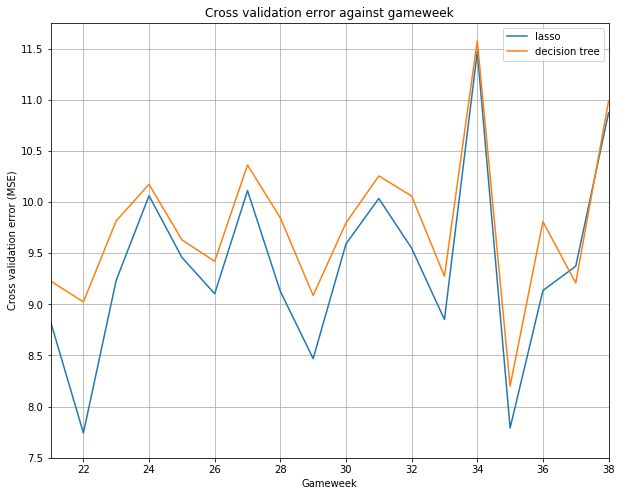

In [432]:
plt.figure(figsize=(10, 8))
plt.plot(lasso_df_test.groupby('event')['squared_error'].mean(), label='lasso')
plt.plot(tree_df_test.groupby('event')['squared_error'].mean(), label='decision tree')
plt.legend()
plt.xlim(21, 38)
plt.ylim(7.5, 11.75)
plt.title('Cross validation error against gameweek')
plt.ylabel('Cross validation error (MSE)')
plt.xlabel('Gameweek')
plt.grid()
plt.show()

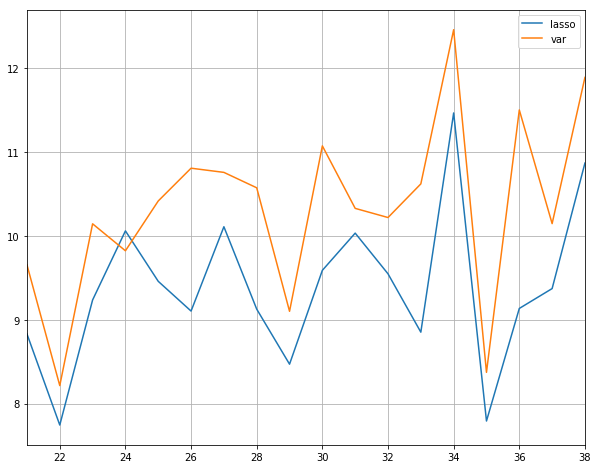

In [411]:
plt.figure(figsize=(10, 8))
plt.plot(lasso_df_test.groupby('event')['squared_error'].mean(), label='lasso')
plt.plot(lasso_df_test.groupby('event')['total_points'].var(), label='var')
# plt.plot(tree_df_test.groupby('event')['squared_error'].mean(), label='decision tree')
plt.legend()
plt.xlim(21, 38)
# plt.ylim(7.5, 11.75)
plt.grid()
plt.show()

##### Error by observed points

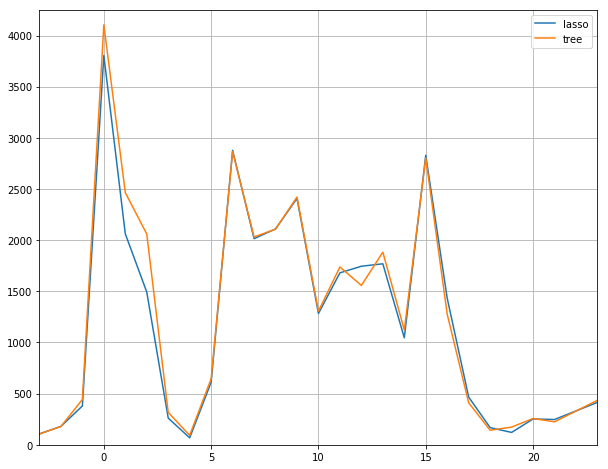

In [422]:
plt.figure(figsize=(10, 8))
plt.plot(lasso_df_test.groupby('total_points')['squared_error'].sum(), label='lasso')
plt.plot(tree_df_test.groupby('total_points')['squared_error'].sum(), label='tree')
plt.legend()
plt.xlim(-3, 23)
plt.ylim(0, 4250)
plt.grid()
plt.show()

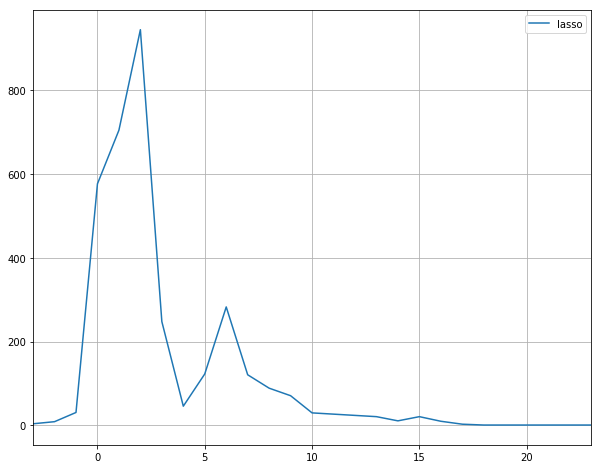

In [428]:
plt.figure(figsize=(10, 8))
plt.plot(lasso_df_test.groupby('total_points')['squared_error'].size(), label='lasso')
plt.legend()
plt.xlim(-3, 23)
# plt.ylim(0, 4250)
plt.grid()
plt.show()

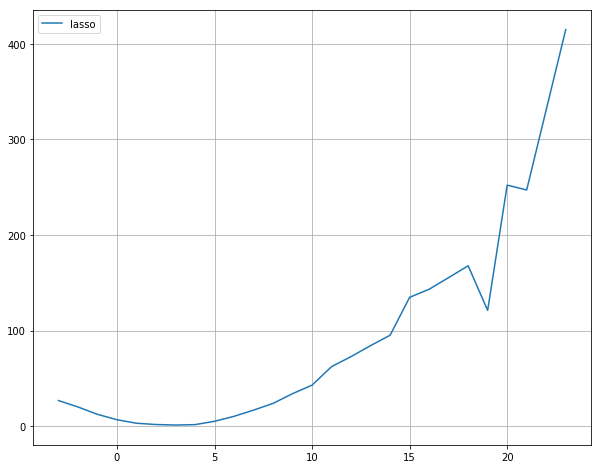

In [425]:
plt.figure(figsize=(10, 8))
plt.plot(lasso_df_test.groupby('total_points')['squared_error'].mean(), label='lasso')
# plt.plot(tree_df_test.groupby('total_points')['squared_error'].sum(), label='tree')
plt.legend()
# plt.xlim(-3, 23)
# plt.ylim(0, 4250)
plt.grid()
plt.show()